---
title: "Cherry Blossoms"
description: "Splines with Numpyro"
author: "Mads Chr. Hansen"
date: "2025-03-09"
categories: [Numpyro]
image: "https://images.unsplash.com/photo-1522383225653-ed111181a951?q=80&w=1476&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
format:
  html:
    code-fold: true
    code-tools: true
toc: true
---

In [ ]:
import os
import warnings

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
import pandas as pd
import seaborn as sns
from jax import random, vmap
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import SVI, Predictive, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [5]:
cherry_blossoms = pd.read_csv(
    "https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/refs/heads/master/data/cherry_blossoms.csv",
    sep=";",
)
d = cherry_blossoms
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      year   1408.00    350.88   1408.00    801.00   1882.00      2.87      2.65


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       doy    104.54      6.41    105.00     93.00    113.00    113.47      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      temp      6.14      0.66      6.10      5.03      7.13     22.43      1.02


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_upper      7.19      0.99      7.04      5.66      8.54     10.66      1.24


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_lower      5.10      0.85      5.14      3.79      6.37     22.35      1.11



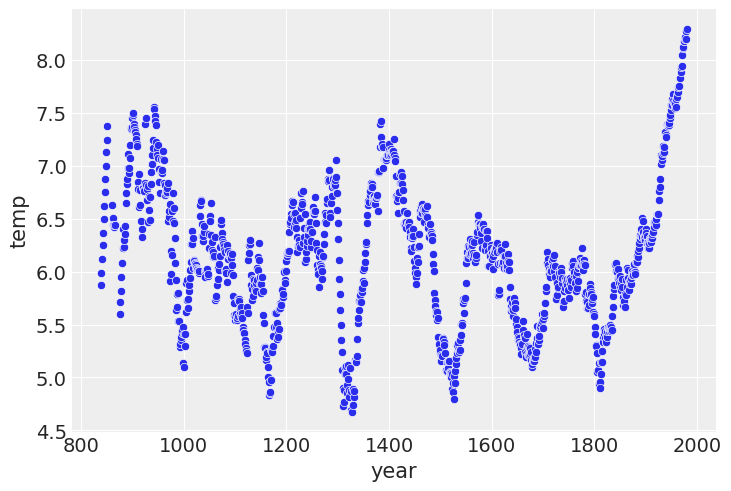

In [10]:
sns.scatterplot(x="year", y="temp", data=d)

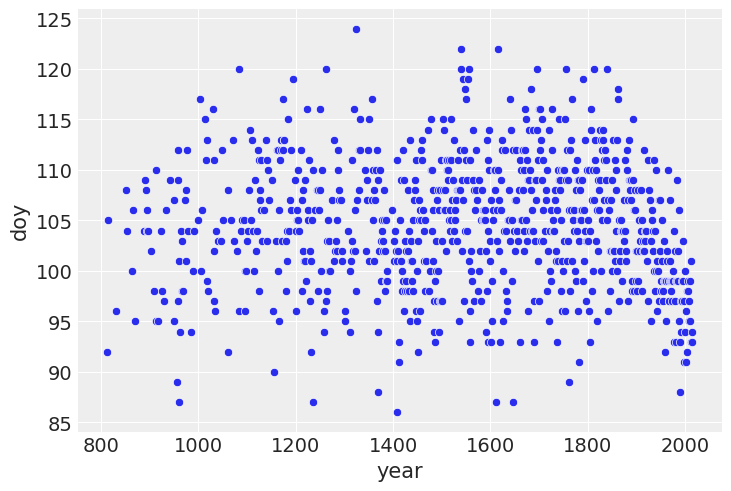

In [11]:
sns.scatterplot(x="year", y="doy", data=d)

We create knots such that the amount of data between the knots are the same. That is, we place the knots at evenly spaced quantiles of the predictor variable, so we have more knots where there is more data.

In [12]:
d2 = d[d.doy.notna()]  # complete cases on doy
num_knots = 15
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
)

In [13]:
knot_list

Array([ 812.    , 1036.0001, 1174.    , 1269.    , 1377.    , 1454.    ,
       1518.    , 1583.    , 1650.0001, 1714.    , 1774.    , 1833.0001,
       1893.0001, 1956.    , 2015.    ], dtype=float32)

In [ ]:
knots = jnp.pad(knot_list, (3, 3), mode="edge")

In [15]:
knots

Array([ 812.    ,  812.    ,  812.    ,  812.    , 1036.0001, 1174.    ,
       1269.    , 1377.    , 1454.    , 1518.    , 1583.    , 1650.0001,
       1714.    , 1774.    , 1833.0001, 1893.0001, 1956.    , 2015.    ,
       2015.    , 2015.    , 2015.    ], dtype=float32)

In [16]:
B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)

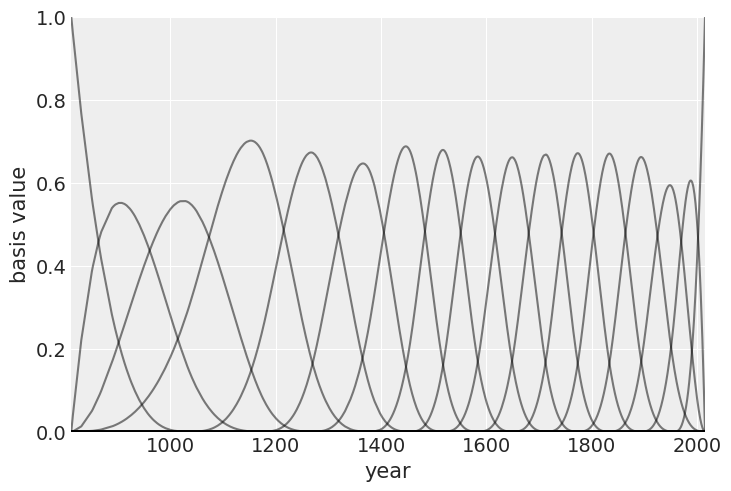

In [19]:
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(0, 1),
    xlabel="year",
    ylabel="basis value",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

\begin{align*}
D_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \sum_{k=1}^{K} w_k B_{k,i}
\end{align*}

In [ ]:
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4_7 = svi_result.params

100%|██████████| 20000/20000 [00:02<00:00, 8635.82it/s, init loss: 23864758.0000, avg. loss [19001-20000]: 2704.9067]


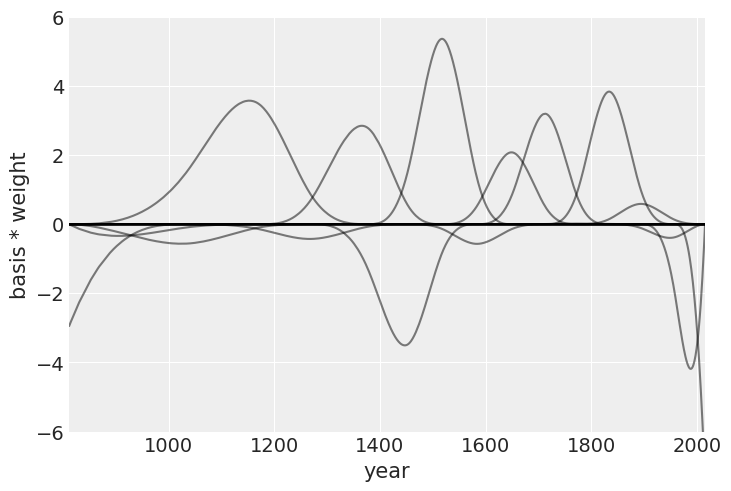

In [21]:
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, sample_shape=(1000,))
w = jnp.mean(post["w"], 0)
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(-6, 6),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)

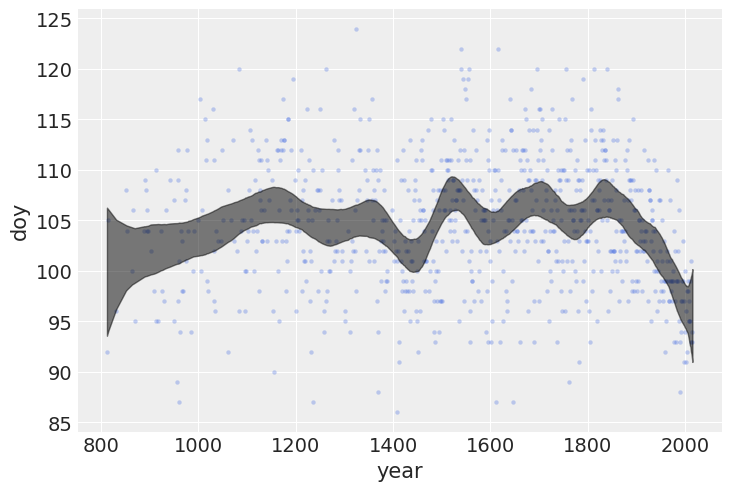

In [ ]:
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"c": "royalblue", "alpha": 0.3, "s": 40},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5)
plt.show()